# Introduction

Name : **Pratikkumar Dalsukhbhai Korat** (Student ID: **017512508**).  
This notebook presents my work and analysis for the given assignment. It includes code implementations, results, and explanations to demonstrate my understanding of the topic.


## Problem 1 : Jack's Car Rental Problem

* The original code was painfully slow -> I took advantage of NVIDIA GPU for parallel computation

The original CPU implementation of **Jack’s Car Rental** used nested Python loops for:
- Every state pair (21 × 21)
- Every action (11)
- Every rental/return combination (≈ 20,000)

This resulted in **tens of thousands of scalar operations per iteration**, leading to runtimes of several minutes.

By rewriting the algorithm in **JAX** with:
- `jit` for XLA compilation
- `vmap` for vectorized parallel computation
- GPU execution instead of scalar CPU loops


JACK'S CAR RENTAL - JAX PARALLEL POLICY ITERATION


### SOLVING ORIGINAL PROBLEM (JAX GPU) ###

Parameters:
- λ rentals: [3, 4] at locations 1, 2
- λ returns: [3, 2] at locations 1, 2
- Max cars: 20 per location
- Max move: 5 cars per night
- Rental credit: $10 per car
- Move cost: $2 per car
- Discount: γ = 0.9

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]


Policy Iteration 1
Policy Evaluation (parallel on GPU):
  Iteration 20, Delta: 6.221924
  Iteration 40, Delta: 0.696289
  Iteration 60, Delta: 0.078857
  Iteration 80, Delta: 0.009033
  Converged in 80 iterations (0.66s)

Policy Improvement (parallel on GPU):
  Completed in 0.20s
  Policy changed: True

Policy Iteration 2
Policy Evaluation (parallel on GPU):
  Iteration 20, Delta: 0.166565
  Iteration 40, Delta: 0.018982
  Converged in 46 iterations (0.14s)

Policy Improvement (parallel on GPU):
  Completed in 0.00s
  Policy changed: True

Policy Iteration 3
Policy Evaluation (parallel on GPU):
  Iteration 20, Delta: 0.067322


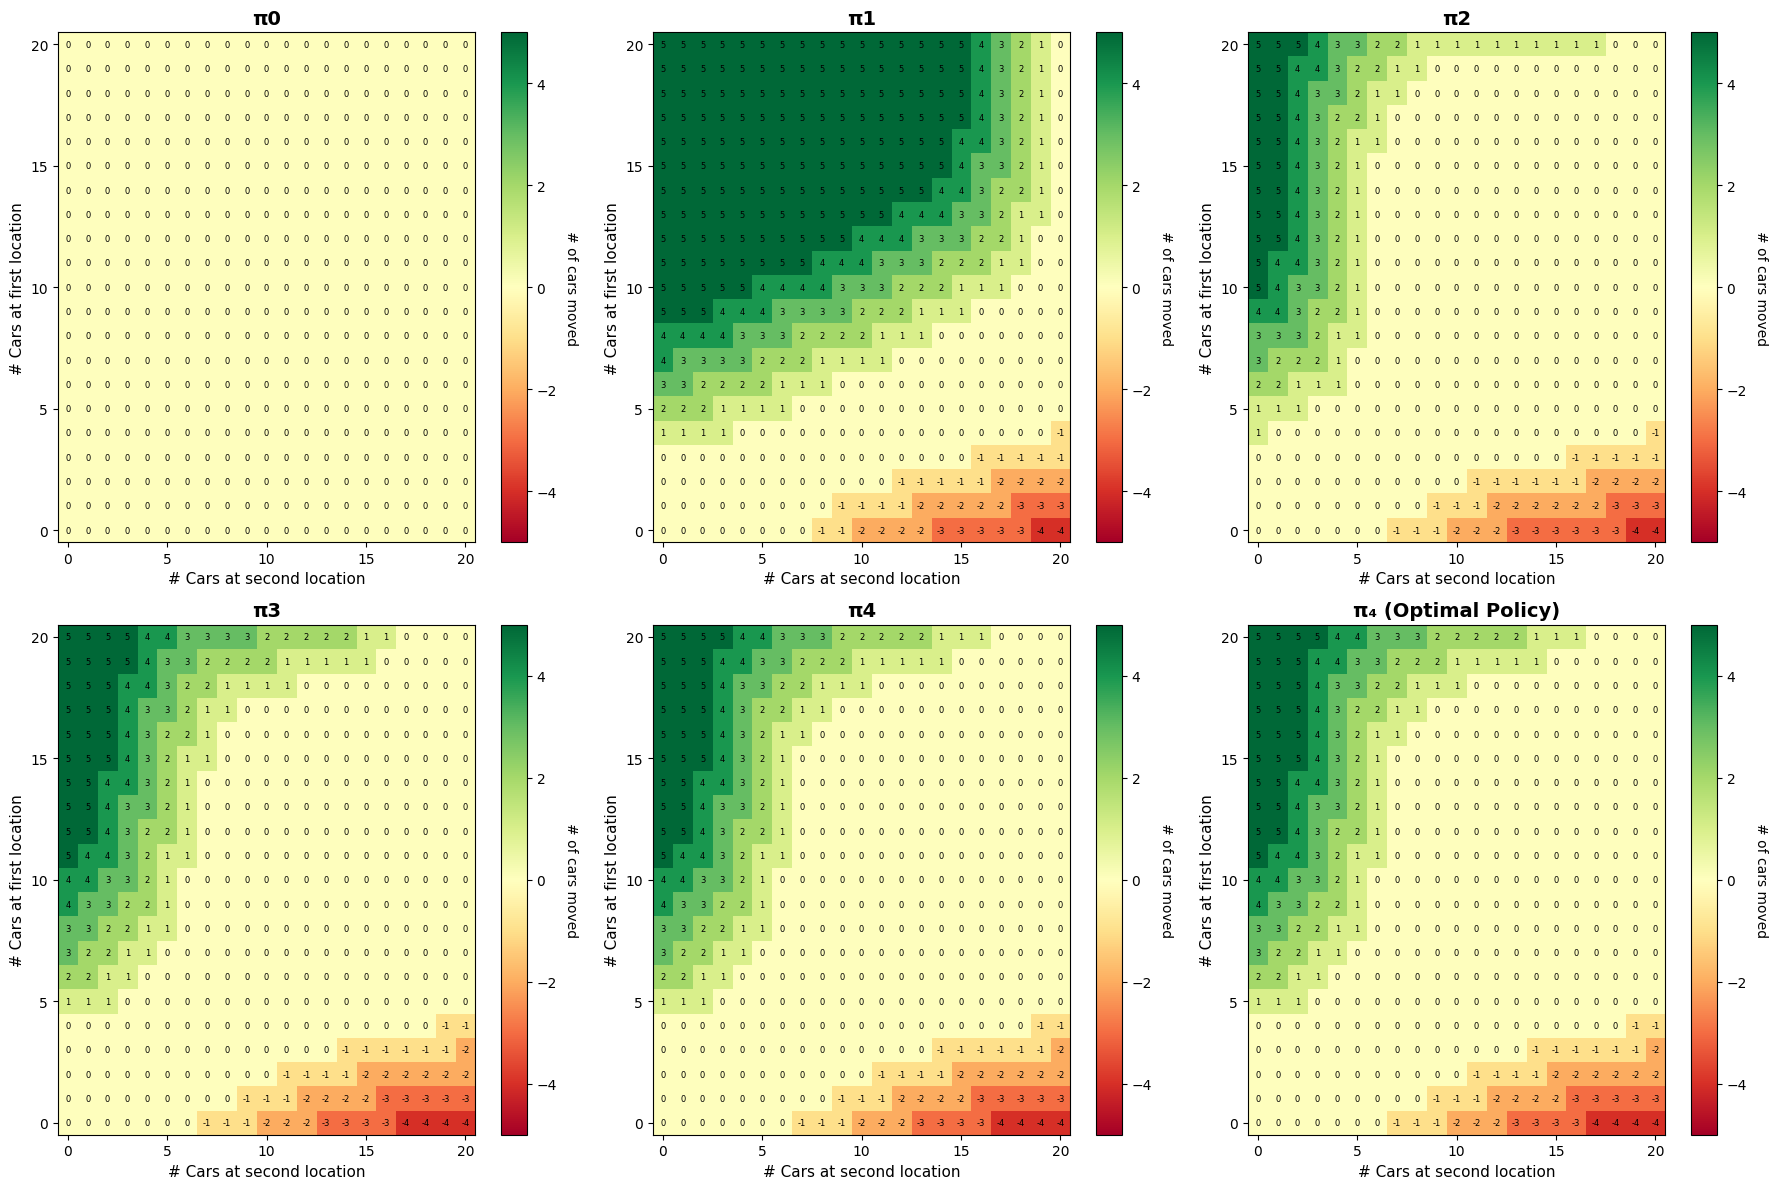

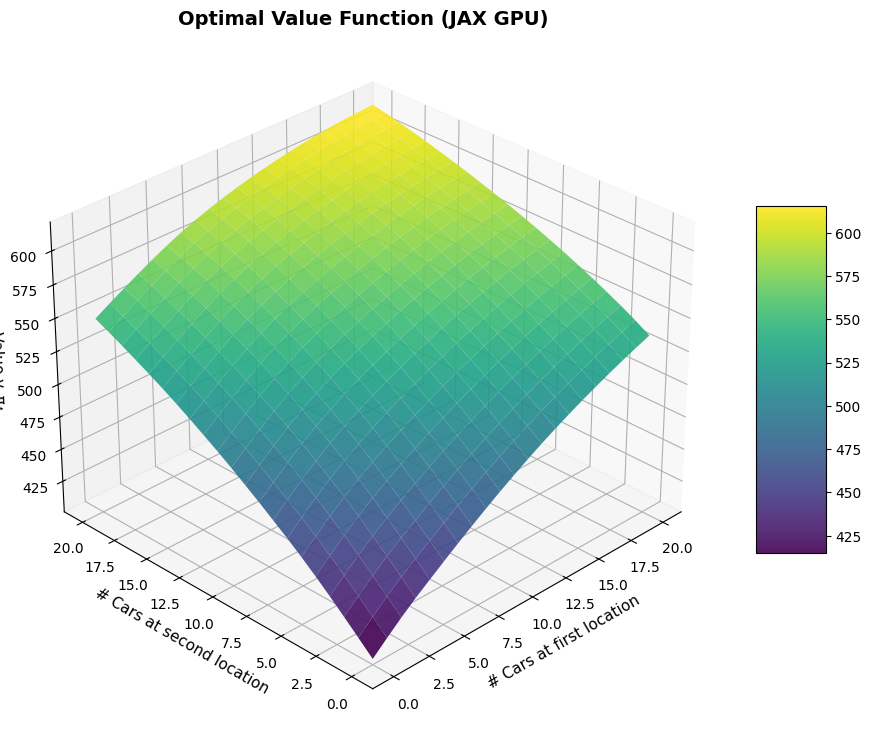



### SOLVING MODIFIED PROBLEM (JAX GPU) ###

Additional modifications:
- Free shuttle: First car from loc1 to loc2 is free
- Parking cost: $4 if more than 10 cars at a location

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]


Policy Iteration 1
Policy Evaluation (parallel on GPU):
  Iteration 20, Delta: 5.865051
  Iteration 40, Delta: 0.662598
  Iteration 60, Delta: 0.075256
  Converged in 79 iterations (0.75s)

Policy Improvement (parallel on GPU):
  Completed in 0.22s
  Policy changed: True

Policy Iteration 2
Policy Evaluation (parallel on GPU):
  Iteration 20, Delta: 0.357178
  Iteration 40, Delta: 0.040588
  Converged in 53 iterations (0.16s)

Policy Improvement (parallel on GPU):
  Completed in 0.00s
  Policy changed: True

Policy Iteration 3
Policy Evaluation (parallel on GPU):
  Iteration 20, Delta: 0.097412
  Converged in 39 iterations (0.11s)

Policy Improvement (parallel on GPU):
  Completed in 0.00s
  Policy changed: True

Policy Iteration 4
Policy Evaluation (parallel 

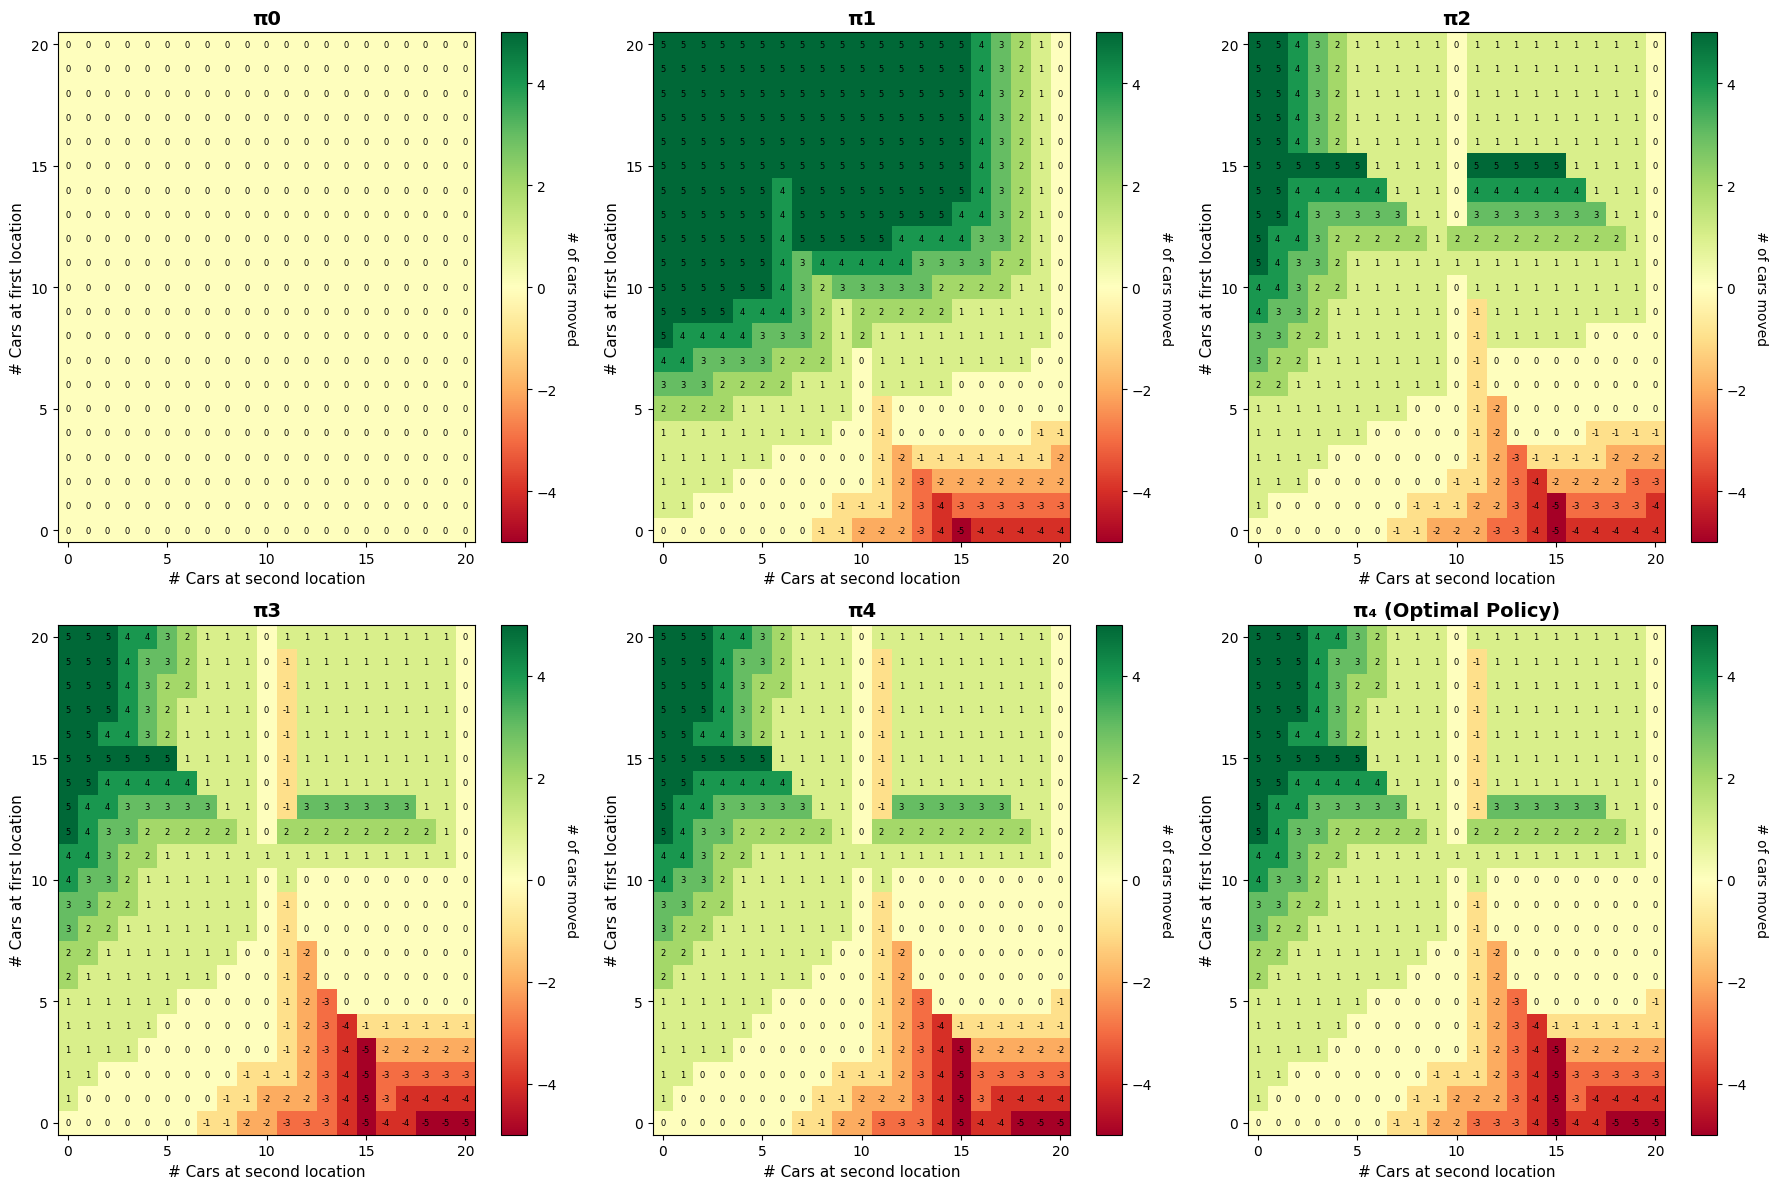

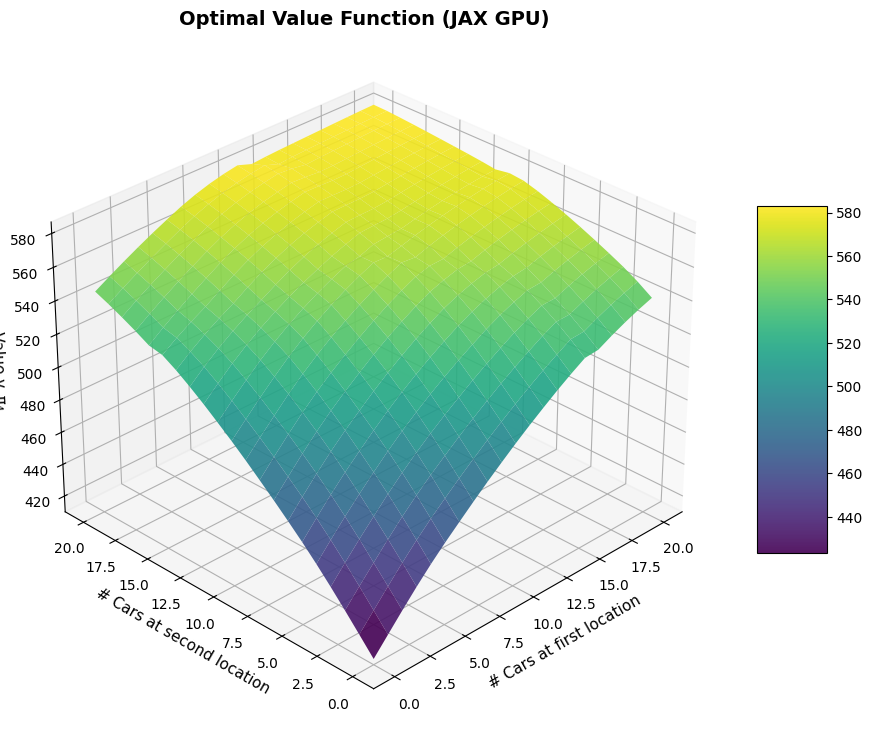



COMPLETE!


In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, vmap
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from functools import partial
import time

class JacksCarRentalJAX:
    def __init__(self, modified=False):
        print(f"JAX backend: {jax.default_backend()}")
        print(f"JAX devices: {jax.devices()}\n")

        # Problem parameters
        self.max_cars = 20
        self.max_move = 5
        self.rental_credit = 10
        self.move_cost = 2
        self.gamma = 0.9

        # Poisson parameters
        self.rental_lambda = jnp.array([3, 4])
        self.return_lambda = jnp.array([3, 2])

        # Modified problem parameters
        self.modified = modified
        self.free_shuttle = 1 if modified else 0
        self.parking_limit = 10
        self.parking_cost = 4

        # Precompute Poisson probabilities
        self.poisson_upper_bound = 11
        self._precompute_poisson_jax()

        # Initialize policy and value function on GPU
        self.policy = jnp.zeros((self.max_cars + 1, self.max_cars + 1), dtype=jnp.int32)
        self.value = jnp.zeros((self.max_cars + 1, self.max_cars + 1))

    def _precompute_poisson_jax(self):
        """Precompute Poisson probabilities using NumPy then transfer to JAX"""
        # Compute using scipy then convert to JAX arrays
        rental_probs_list = []
        for lam in [3, 4]:  # rental lambdas
            probs = [poisson.pmf(n, lam) for n in range(self.poisson_upper_bound)]
            probs.append(1.0 - poisson.cdf(self.poisson_upper_bound - 1, lam))
            rental_probs_list.append(probs)

        return_probs_list = []
        for lam in [3, 2]:  # return lambdas
            probs = [poisson.pmf(n, lam) for n in range(self.poisson_upper_bound)]
            probs.append(1.0 - poisson.cdf(self.poisson_upper_bound - 1, lam))
            return_probs_list.append(probs)

        # Convert to JAX arrays
        self.rental_probs = jnp.array(rental_probs_list)  # Shape: (2, 11)
        self.return_probs = jnp.array(return_probs_list)  # Shape: (2, 11)

    @partial(jit, static_argnums=(0,))
    def _compute_move_cost(self, action):
        """Compute cost of moving cars"""
        if self.modified:
            cost = jnp.where(
                action > 0,
                self.move_cost * jnp.maximum(0, action - self.free_shuttle),
                self.move_cost * jnp.abs(action)
            )
        else:
            cost = self.move_cost * jnp.abs(action)
        return cost

    @partial(jit, static_argnums=(0,))
    def _compute_parking_cost(self, cars1, cars2):
        """Compute parking cost"""
        if self.modified:
            cost = jnp.where(cars1 > self.parking_limit, self.parking_cost, 0.0)
            cost += jnp.where(cars2 > self.parking_limit, self.parking_cost, 0.0)
            return cost
        return 0.0

    @partial(jit, static_argnums=(0,))
    def _expected_return_single(self, state_i, state_j, action, value):
        """Compute expected return for a single state-action pair"""
        # Move cost
        move_cost = self._compute_move_cost(action)

        # State after moving
        cars1 = state_i - action
        cars2 = state_j + action

        # Parking cost
        parking_cost = self._compute_parking_cost(cars1, cars2)

        total_cost = move_cost + parking_cost

        # Create grids for rental and return combinations
        rental1_idx = jnp.arange(self.poisson_upper_bound)
        rental2_idx = jnp.arange(self.poisson_upper_bound)
        return1_idx = jnp.arange(self.poisson_upper_bound)
        return2_idx = jnp.arange(self.poisson_upper_bound)

        # Meshgrid for all combinations
        R1, R2, RT1, RT2 = jnp.meshgrid(
            rental1_idx, rental2_idx, return1_idx, return2_idx,
            indexing='ij'
        )

        # Actual rentals (capped by availability)
        actual_rental1 = jnp.minimum(R1, cars1)
        actual_rental2 = jnp.minimum(R2, cars2)

        # Reward from rentals
        reward = self.rental_credit * (actual_rental1 + actual_rental2)

        # Cars after rentals
        cars1_after_rental = cars1 - actual_rental1
        cars2_after_rental = cars2 - actual_rental2

        # Next state (after returns, capped at max_cars)
        next_cars1 = jnp.minimum(cars1_after_rental + RT1, self.max_cars)
        next_cars2 = jnp.minimum(cars2_after_rental + RT2, self.max_cars)

        # Probabilities
        prob_rental1 = self.rental_probs[0, R1]
        prob_rental2 = self.rental_probs[1, R2]
        prob_return1 = self.return_probs[0, RT1]
        prob_return2 = self.return_probs[1, RT2]

        total_prob = prob_rental1 * prob_rental2 * prob_return1 * prob_return2

        # Expected return
        next_value = value[next_cars1, next_cars2]
        expected = total_prob * (reward + self.gamma * next_value)

        return -total_cost + jnp.sum(expected)

    @partial(jit, static_argnums=(0,))
    def _get_action_mask(self, state_i, state_j):
        """Get valid action mask for a state"""
        actions = jnp.arange(-self.max_move, self.max_move + 1)

        # Check all constraints
        valid = jnp.ones_like(actions, dtype=bool)
        valid = valid & (actions <= state_i)  # Can't move more than available at loc1
        valid = valid & (-actions <= state_j)  # Can't move more than available at loc2
        valid = valid & ((state_i - actions) <= self.max_cars)  # Don't exceed max at loc1
        valid = valid & ((state_j + actions) <= self.max_cars)  # Don't exceed max at loc2
        valid = valid & ((state_i - actions) >= 0)  # Non-negative at loc1
        valid = valid & ((state_j + actions) >= 0)  # Non-negative at loc2

        return valid

    @partial(jit, static_argnums=(0,))
    def _policy_evaluation_single_state(self, state_i, state_j, action, value):
        """Evaluate a single state under current policy"""
        return self._expected_return_single(state_i, state_j, action, value)

    @partial(jit, static_argnums=(0,))
    def _policy_improvement_single_state(self, state_i, state_j, value):
        """Find best action for a single state"""
        actions = jnp.arange(-self.max_move, self.max_move + 1)
        action_mask = self._get_action_mask(state_i, state_j)

        # Compute Q-values for all actions
        def compute_q(action):
            return jnp.where(
                action_mask[action + self.max_move],
                self._expected_return_single(state_i, state_j, action, value),
                -jnp.inf
            )

        q_values = vmap(compute_q)(actions)
        best_action = actions[jnp.argmax(q_values)]

        return best_action

    @partial(jit, static_argnums=(0,))
    def _evaluate_all_states_parallel(self, policy, value):
        """Evaluate all states in parallel"""
        states_i = jnp.arange(self.max_cars + 1)
        states_j = jnp.arange(self.max_cars + 1)

        # Vectorize over both dimensions
        eval_row = vmap(lambda i, j, a: self._policy_evaluation_single_state(i, j, a, value),
                       in_axes=(None, 0, 0))
        eval_all = vmap(lambda i: eval_row(i, states_j, policy[i]), in_axes=0)

        return eval_all(states_i)

    @partial(jit, static_argnums=(0,))
    def _improve_all_states_parallel(self, value):
        """Improve policy for all states in parallel"""
        states_i = jnp.arange(self.max_cars + 1)
        states_j = jnp.arange(self.max_cars + 1)

        # Vectorize over both dimensions
        improve_row = vmap(lambda i, j: self._policy_improvement_single_state(i, j, value),
                          in_axes=(None, 0))
        improve_all = vmap(lambda i: improve_row(i, states_j), in_axes=0)

        return improve_all(states_i)

    def policy_iteration(self, theta=0.01, max_iterations=10):
        """Run policy iteration with JAX parallelization"""
        iteration = 0
        policies = [np.array(self.policy)]

        while iteration < max_iterations:
            iteration += 1
            print(f"\n{'='*60}")
            print(f"Policy Iteration {iteration}")
            print(f"{'='*60}")

            # Policy Evaluation
            print("Policy Evaluation (parallel on GPU):")
            eval_iter = 0
            eval_start = time.time()

            while True:
                old_value = self.value
                self.value = self._evaluate_all_states_parallel(self.policy, self.value)

                delta = float(jnp.max(jnp.abs(self.value - old_value)))
                eval_iter += 1

                if eval_iter % 20 == 0:
                    print(f"  Iteration {eval_iter}, Delta: {delta:.6f}")

                if delta < theta:
                    break

            eval_time = time.time() - eval_start
            print(f"  Converged in {eval_iter} iterations ({eval_time:.2f}s)")

            # Policy Improvement
            print("\nPolicy Improvement (parallel on GPU):")
            improve_start = time.time()

            old_policy = self.policy
            self.policy = self._improve_all_states_parallel(self.value)

            improve_time = time.time() - improve_start
            print(f"  Completed in {improve_time:.2f}s")

            policies.append(np.array(self.policy))

            # Check convergence
            policy_changed = not jnp.all(self.policy == old_policy)
            print(f"  Policy changed: {policy_changed}")

            if not policy_changed:
                print(f"\nPolicy converged after {iteration} iterations!")
                break

        return policies

    def plot_policies(self, policies):
        """Plot the sequence of policies"""
        n_policies = len(policies)
        n_plots = min(6, n_policies)

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        for idx in range(n_plots):
            policy = policies[idx]
            ax = axes[idx]

            im = ax.imshow(policy, cmap='RdYlGn', origin='lower',
                          vmin=-5, vmax=5, aspect='auto')

            # Add annotations
            for i in range(self.max_cars + 1):
                for j in range(self.max_cars + 1):
                    ax.text(j, i, int(policy[i, j]),
                           ha="center", va="center", color="black", fontsize=6)

            if idx == n_policies - 1:
                ax.set_title(f'π₄ (Optimal Policy)', fontsize=14, fontweight='bold')
            else:
                ax.set_title(f'π{idx}', fontsize=14, fontweight='bold')

            ax.set_xlabel('# Cars at second location', fontsize=11)
            ax.set_ylabel('# Cars at first location', fontsize=11)
            ax.set_xticks(np.arange(0, 21, 5))
            ax.set_yticks(np.arange(0, 21, 5))

            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label('# of cars moved', rotation=270, labelpad=15)

        for idx in range(n_plots, 6):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.savefig('policies_jax.png', dpi=150, bbox_inches='tight')
        plt.show()

    def plot_value_function(self):
        """Plot the final value function"""
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')

        x = np.arange(0, self.max_cars + 1)
        y = np.arange(0, self.max_cars + 1)
        X, Y = np.meshgrid(x, y)

        value_np = np.array(self.value)
        surf = ax.plot_surface(X, Y, value_np.T, cmap=cm.viridis,
                              linewidth=0, antialiased=True, alpha=0.9)

        ax.set_xlabel('# Cars at first location', fontsize=11)
        ax.set_ylabel('# Cars at second location', fontsize=11)
        ax.set_zlabel('Value v_π₄', fontsize=11)
        ax.set_title('Optimal Value Function (JAX GPU)', fontsize=14, fontweight='bold')

        ax.view_init(elev=30, azim=225)

        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.savefig('value_function_jax.png', dpi=150, bbox_inches='tight')
        plt.show()


def main():
    print("="*60)
    print("JACK'S CAR RENTAL - JAX PARALLEL POLICY ITERATION")
    print("="*60)

    # Solve original problem
    print("\n\n### SOLVING ORIGINAL PROBLEM (JAX GPU) ###\n")
    print("Parameters:")
    print("- λ rentals: [3, 4] at locations 1, 2")
    print("- λ returns: [3, 2] at locations 1, 2")
    print("- Max cars: 20 per location")
    print("- Max move: 5 cars per night")
    print("- Rental credit: $10 per car")
    print("- Move cost: $2 per car")
    print("- Discount: γ = 0.9\n")

    start = time.time()

    original = JacksCarRentalJAX(modified=False)
    policies_original = original.policy_iteration()

    elapsed = time.time() - start
    print(f"\n\n{'='*60}")
    print(f"ORIGINAL PROBLEM - Total Time: {elapsed:.2f} seconds")
    print(f"{'='*60}")

    print("\n\nPlotting results...")
    original.plot_policies(policies_original)
    original.plot_value_function()

    # Solve modified problem
    print("\n\n### SOLVING MODIFIED PROBLEM (JAX GPU) ###\n")
    print("Additional modifications:")
    print("- Free shuttle: First car from loc1 to loc2 is free")
    print("- Parking cost: $4 if more than 10 cars at a location\n")

    start = time.time()

    modified = JacksCarRentalJAX(modified=True)
    policies_modified = modified.policy_iteration()

    elapsed = time.time() - start
    print(f"\n\n{'='*60}")
    print(f"MODIFIED PROBLEM - Total Time: {elapsed:.2f} seconds")
    print(f"{'='*60}")

    print("\n\nPlotting results...")
    modified.plot_policies(policies_modified)
    modified.plot_value_function()

    print("\n\n" + "="*60)
    print("COMPLETE!")
    print("="*60)


if __name__ == "__main__":
    main()

## Reflection on Jack's Car Rental

This study shows how reinforcement learning, through policy iteration, can efficiently solve Jack’s Car Rental problem—a classic resource allocation challenge under uncertainty. By repeatedly improving the policy based on expected returns, the method learns how to move cars between locations to maximize long-term profit while accounting for random customer demand. The findings confirm the effectiveness of dynamic programming in balancing immediate rewards with future opportunities, demonstrating how reinforcement learning principles translate into optimal, data-driven decisions for real-world logistics and inventory management.

## Problem 2 : Gambler's Problem - Value Iteration



EXPERIMENT 1: p_h = 0.25
Value Iteration: p_h = 0.25
--------------------------------------------------
Sweep   1: Delta = 0.82202148
Sweep   2: Delta = 0.19067383
Sweep   5: Delta = 0.00267029
Sweep  10: Delta = 0.00000136
Converged at sweep 11
--------------------------------------------------


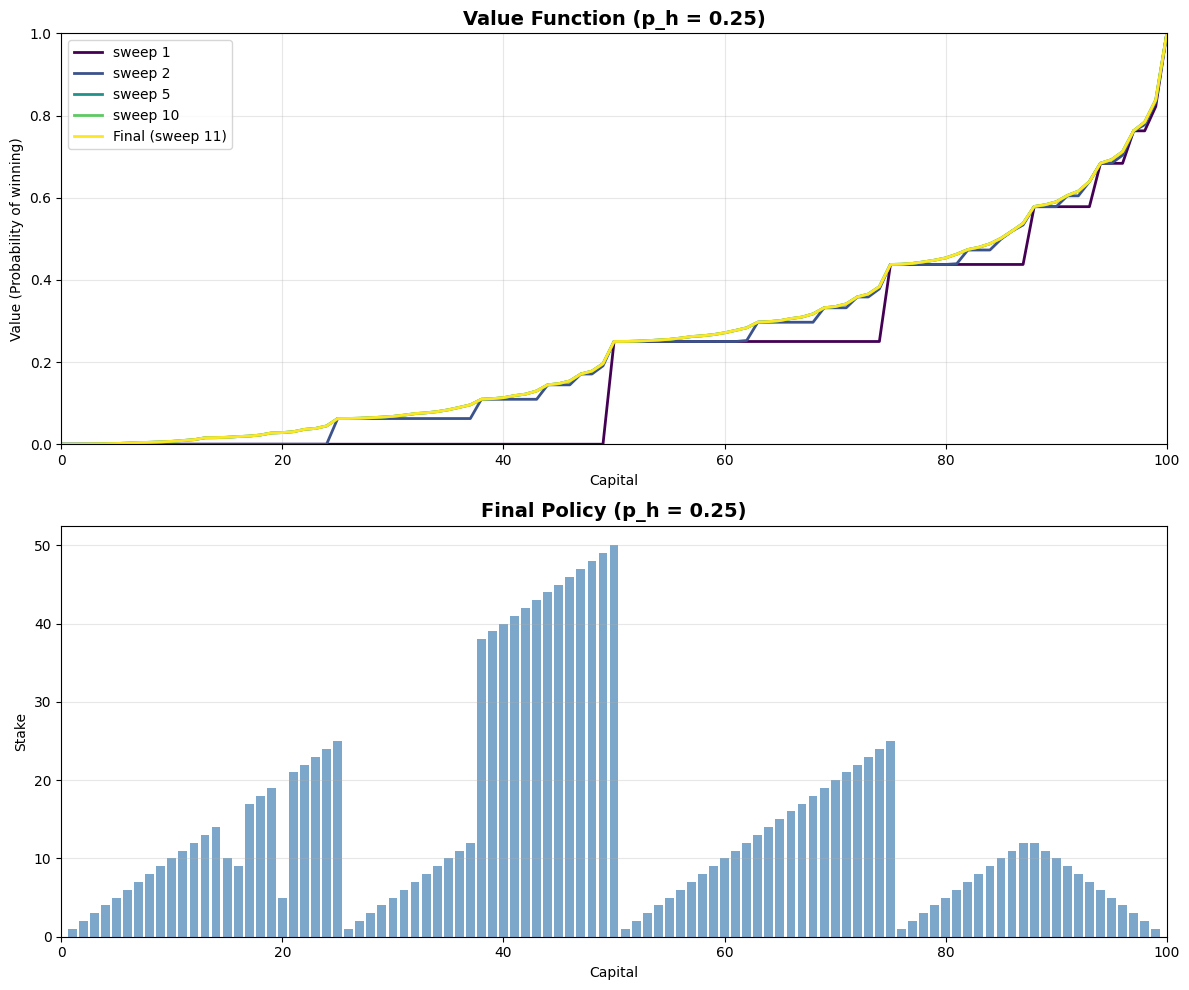


EXPERIMENT 2: p_h = 0.55
Value Iteration: p_h = 0.55
--------------------------------------------------
Sweep   1: Delta = 0.99169623
Sweep   2: Delta = 0.53985095
Sweep   5: Delta = 0.08775392
Sweep  10: Delta = 0.00957991
Sweep  20: Delta = 0.00647411
Sweep  50: Delta = 0.00395592
Sweep 100: Delta = 0.00264058
--------------------------------------------------


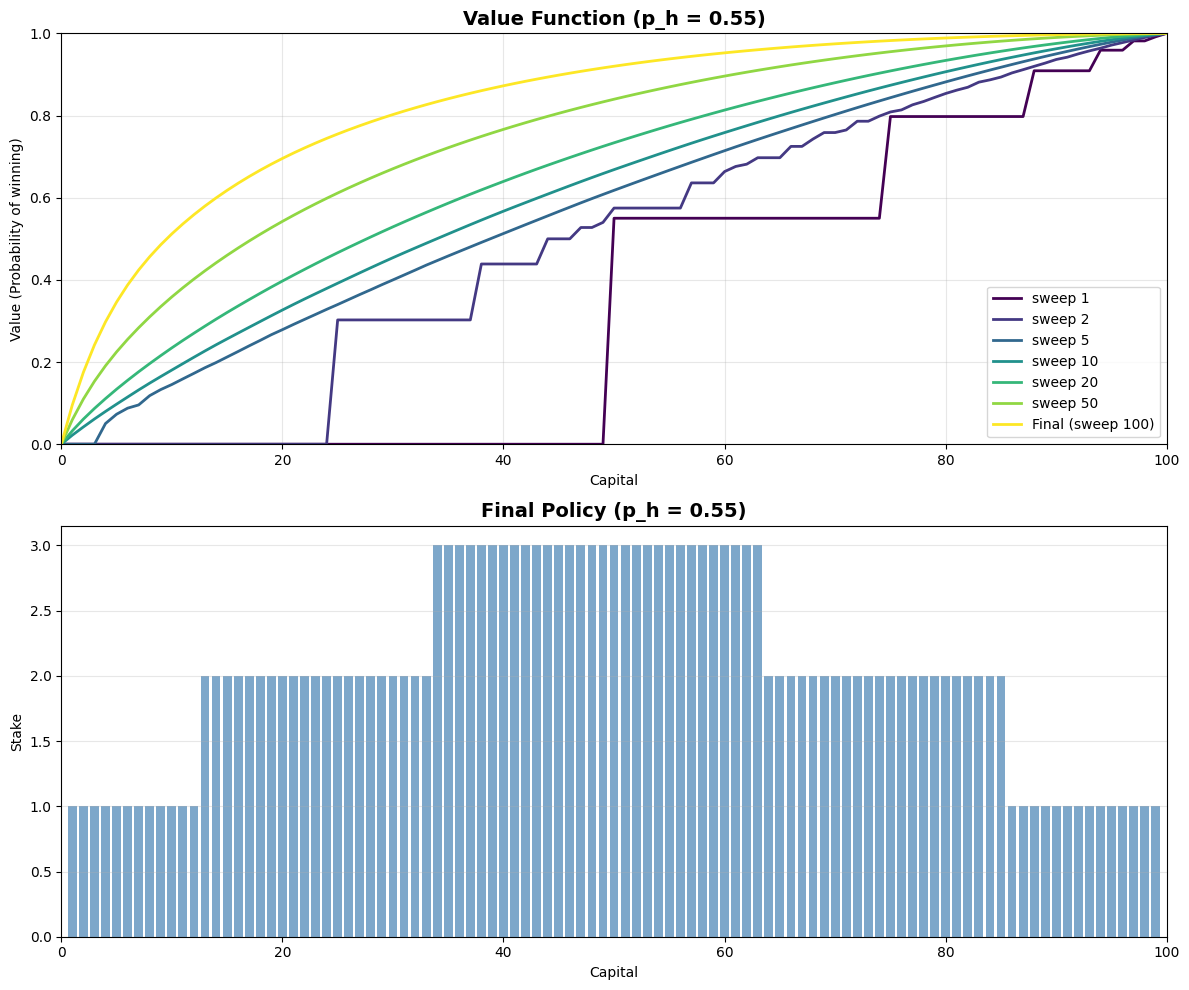


✓ Complete!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class GamblersProblem:
    """Value Iteration for Gambler's Problem"""

    def __init__(self, p_h=0.4, goal=100):
        self.p_h = p_h
        self.goal = goal

        # Initialize value function
        # V(0) = 0 (lose), V(100) = 1 (win), V(1..99) = 0
        self.value = np.zeros(goal + 1)
        self.value[goal] = 1.0

        # Initialize policy
        self.policy = np.zeros(goal + 1, dtype=int)

    def value_iteration(self, theta=1e-6, max_sweeps=100):
        """Run value iteration algorithm to find optimal value function"""
        value_history = {}
        policy_history = {}
        checkpoint_sweeps = [1, 2, 5, 10, 20, 50, 100]

        print(f"Value Iteration: p_h = {self.p_h}")
        print("-" * 50)

        for sweep in range(1, max_sweeps + 1):
            delta = 0

            # Update each state
            for state in range(1, self.goal):
                old_v = self.value[state]

                # Try all possible actions (stakes)
                max_stake = min(state, self.goal - state)
                action_values = []

                for action in range(1, max_stake + 1):
                    # Win: go to state + action
                    # Lose: go to state - action
                    q_value = (self.p_h * self.value[state + action] +
                              (1 - self.p_h) * self.value[state - action])
                    action_values.append(q_value)

                # Bellman optimality: take max
                self.value[state] = max(action_values)
                delta = max(delta, abs(old_v - self.value[state]))

            # Save checkpoints
            if sweep in checkpoint_sweeps:
                value_history[sweep] = np.copy(self.value)
                policy_history[sweep] = self.extract_policy()
                print(f"Sweep {sweep:3d}: Delta = {delta:.8f}")

            # Check convergence
            if delta < theta:
                print(f"Converged at sweep {sweep}")
                if sweep not in checkpoint_sweeps:
                    value_history[sweep] = np.copy(self.value)
                    policy_history[sweep] = self.extract_policy()
                break

        print("-" * 50)
        return value_history, policy_history

    def extract_policy(self):
        """Extract optimal policy from value function"""
        policy = np.zeros(self.goal + 1, dtype=int)

        for state in range(1, self.goal):
            max_stake = min(state, self.goal - state)

            best_action = 1
            best_value = -float('inf')

            for action in range(1, max_stake + 1):
                q_value = (self.p_h * self.value[state + action] +
                          (1 - self.p_h) * self.value[state - action])

                if q_value > best_value:
                    best_value = q_value
                    best_action = action

            policy[state] = best_action

        return policy

    def plot_results(self, value_history, policy_history):
        """Plot value function and policy"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Plot value function evolution
        ax1.set_title(f'Value Function (p_h = {self.p_h})',
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('Capital')
        ax1.set_ylabel('Value (Probability of winning)')

        sweeps = sorted(value_history.keys())
        colors = plt.cm.viridis(np.linspace(0, 1, len(sweeps)))

        for idx, sweep in enumerate(sweeps):
            label = f'sweep {sweep}'
            if sweep == sweeps[-1]:
                label = f'Final (sweep {sweep})'
            ax1.plot(value_history[sweep], label=label,
                    color=colors[idx], linewidth=2)

        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim([0, 100])
        ax1.set_ylim([0, 1])

        # Plot final policy
        final_policy = policy_history[sweeps[-1]]

        ax2.set_title(f'Final Policy (p_h = {self.p_h})',
                     fontsize=14, fontweight='bold')
        ax2.set_xlabel('Capital')
        ax2.set_ylabel('Stake')
        ax2.bar(range(1, self.goal), final_policy[1:self.goal],
               color='steelblue', alpha=0.7)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_xlim([0, 100])

        plt.tight_layout()
        plt.show()

# ============================================================================
# Main Execution
# ============================================================================
if __name__ == "__main__":

    # Experiment 1: p_h = 0.25 (Unfavorable odds)
    print("="*60)
    print("EXPERIMENT 1: p_h = 0.25")
    print("="*60)

    solver_025 = GamblersProblem(p_h=0.25)
    value_hist_025, policy_hist_025 = solver_025.value_iteration(theta=1e-6)
    solver_025.plot_results(value_hist_025, policy_hist_025)

    # Experiment 2: p_h = 0.55 (Favorable odds)
    print("\n" + "="*60)
    print("EXPERIMENT 2: p_h = 0.55")
    print("="*60)

    solver_055 = GamblersProblem(p_h=0.55)
    value_hist_055, policy_hist_055 = solver_055.value_iteration(theta=1e-6)
    solver_055.plot_results(value_hist_055, policy_hist_055)

    print("\n Complete!")

## Reflection on Gambler's problem

These results visualize how dynamic programming (value iteration) computes both:

* The value function (expected success probability per capital), and
* The optimal policy (best stake at each state).

It demonstrates that:

* With iterative improvement, value estimates converge smoothly to the true optimal values.
* The resulting policy is structured and interpretable: small bets near terminal risks, larger bets in safer mid-capitals.

This confirms the theoretical insight of the Gambler’s Problem: reinforcement learning and dynamic programming can produce optimal, interpretable betting strategies in stochastic environments.